In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
import time
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
%matplotlib inline
random = 40

In [2]:
# defining visualizaition functions
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):

    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
        
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    format_spines(ax)

    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

def plot_roc_curve(fpr, tpr, label=None):
    """
    this function plots the ROC curve of a model
    
    input:
        fpr: false positive rate
        tpr: true positive rate
    returns:
        ROC curve
    """
    
    # Showing data
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function set up and plot a Confusion Matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Format plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def create_dataset():
    """
    This functions creates a dataframe to keep performance analysis
    """
    attributes = ['acc', 'prec', 'rec', 'f1', 'auc', 'total_time']
    model_performance = pd.DataFrame({})
    for col in attributes:
        model_performance[col] = []
    return model_performance

def model_analysis(classifiers, X, y, df_performance, cv=5, train=True):
    """
    This function brings up a full model evaluation and saves it in a DataFrame object.
    """
    for key, model in classifiers.items():
        t0 = time.time()
        
        # Accuracy, precision, recall and f1_score on training set using cv
        if train:
            acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
            prec = cross_val_score(model, X, y, cv=cv, scoring='precision').mean()
            rec = cross_val_score(model, X, y, cv=cv, scoring='recall').mean()
            f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
        else:
            y_pred = model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred)
            rec = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
        
        # AUC score
        try:
            y_scores = cross_val_predict(model, X, y, cv=5, 
                                     method='decision_function')
        except:
            # Trees don't have decision_function but predict_proba
            y_probas = cross_val_predict(model, X, y, cv=5, 
                                         method='predict_proba')
            y_scores_tree = y_probas[:, 1]
            y_scores = y_scores_tree
        auc = roc_auc_score(y, y_scores)
        
        t1 = time.time()
        delta_time = t1-t0
        model_name = model.__class__.__name__
        
        # Saving on dataframe
        performances = {}
        performances['acc'] = round(acc, 4)
        performances['prec'] = round(prec, 4)
        performances['rec'] = round(rec, 4)
        performances['f1'] = round(f1, 4)
        performances['auc'] = round(auc, 4)
        performances['total_time'] = round(delta_time, 3)
        
        df_performance = df_performance.append(performances, ignore_index=True)
    df_performance.index = classifiers.keys()
    
    return df_performance

def model_confusion_matrix(classifiers, X, y, cmap=plt.cm.Blues):
    """
    This function computes predictions for all model and plots a confusion matrix
    for each one.
    """
    i = 1
    plt.figure(figsize=(19, 8))
    sns.set(style='white', palette='muted', color_codes=True)
    labels = ['Positive', 'Negative']
    
    # Ploting confusion matrix
    for key, model in classifiers.items(): 
        y_pred = model.predict(X)
        model_cf_mx = confusion_matrix(y, y_pred)

        # Plotando matriz
        model_name = model.__class__.__name__
        plt.subplot(2, 3, i)
        plot_confusion_matrix(model_cf_mx, labels, title=model_name + '\nConfusion Matrix', cmap=cmap)
        i += 1

    plt.tight_layout()
    plt.show()
    
def plot_roc_curve(fpr, tpr, y, y_scores, auc, label=None):
    """
    This function plots the ROC curve of a model
    """   
    # Showing data
    sns.set(style='white', palette='muted', color_codes=True)
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}, auc={auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.02, 1.02, -0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve', size=14)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.4),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
def plot_precision_vs_recall(precisions, recalls, label=None, color='b'):
    """
    This function plots precision versus recall curve.
    """
    sns.set(style='white', palette='muted', color_codes=True)
    if label=='LogisticRegression':
        plt.plot(recalls, precisions, 'r-', linewidth=2, label=label)
    else:
        plt.plot(recalls, precisions, color=color, linewidth=2, label=label)
    plt.title('Precision versus Recall', fontsize=14)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    This function plots precision x recall among different thresholds
    """
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.title('Precision versus Recall - Thresholds', size=14)
    plt.legend(loc='best')
    plt.ylim([0, 1])
    
def plot_learning_curve(trained_models, X, y, ylim=None, cv=5, n_jobs=1, 
                        train_sizes=np.linspace(.1, 1.0, 10)):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
    if ylim is not None:
        plt.ylim(*ylim)
    i = 0
    j = 0
    for key, model in trained_models.items():
        train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, 
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        axs[i, j].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        axs[i, j].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1, color='crimson')
        axs[i, j].plot(train_sizes, train_scores_mean, 'o-', color="navy",
                       label="Training score")
        axs[i, j].plot(train_sizes, test_scores_mean, 'o-', color="red",
                       label="Cross-Validation score")
        axs[i, j].set_title(f'{key} Learning Curve', size=14)
        axs[i, j].set_xlabel('Training size (m)')
        axs[i, j].set_ylabel('Score')
        axs[i, j].grid(True)
        axs[i, j].legend(loc='best')
        j += 1
        if j == 2:
            i += 1
            j = 0

In [3]:
df = pd.read_csv('Desktop/DS ToolKit/DataSet/train_technidus_clf.csv')
df_test = pd.read_csv('Desktop/DS ToolKit/DataSet/test_technidus_clf.csv')

In [4]:
# displaying first three rows of dataset
df.head(3)

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer
0,14540.0,NaN,Randy,NaN,Lin,NaN,8848 Auburn,NaN,London,England,United Kingdom,W1Y 3RA,1 (11) 500 555-0138,4/18/1958,Bachelors,Manual,M,M,1.0,0.0,0.0,1.0,35455.0,70.0,1
1,18054.0,NaN,Jake,NaN,Zeng,NaN,4058 First Ave,NaN,Cliffside,British Columbia,Canada,V8Y 1L1,987-555-0118,10/6/1960,Bachelors,Professional,M,S,0.0,1.0,0.0,0.0,43980.0,69.0,0
2,16955.0,NaN,Nathaniel,NaN,Bradley,NaN,3679 Diablo View Road,NaN,Metchosin,British Columbia,Canada,V9,145-555-0167,8/18/1969,Bachelors,Skilled Manual,M,M,1.0,0.0,2.0,2.0,57713.0,102.0,0


In [5]:
# displaying dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7686 entries, 0 to 7685
Data columns (total 25 columns):
CustomerID              7685 non-null float64
Title                   41 non-null object
FirstName               7685 non-null object
MiddleName              4457 non-null object
LastName                7685 non-null object
Suffix                  1 non-null object
AddressLine1            7685 non-null object
AddressLine2            135 non-null object
City                    7685 non-null object
StateProvinceName       7685 non-null object
CountryRegionName       7685 non-null object
PostalCode              7685 non-null object
PhoneNumber             7685 non-null object
BirthDate               7685 non-null object
Education               7685 non-null object
Occupation              7685 non-null object
Gender                  7685 non-null object
MaritalStatus           7685 non-null object
HomeOwnerFlag           7685 non-null float64
NumberCarsOwned         7685 non-null floa

In [6]:
# displaying summary staticstics of columns
df.describe(include='all')

,CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,CountryRegionName,PostalCode,PhoneNumber,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer
count,7685.000000,41,7685,4457,7685,1,7685,135,7685,7685,7685,7685,7685,7685,7685,7685,7685,7685,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7685.000000,7686.000000
unique,NaN,3,606,39,296,1,6581,88,250,45,6,301,3882,5173,5,5,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Mr.,Jennifer,L,Diaz,Jr.,Attaché de Presse,Verkaufsabteilung,London,California,United States,97005,1 (11) 500 555-0115,6/24/1964,Bachelors,Professional,M,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,23,44,513,85,1,11,12,183,1826,3226,93,95,6,2294,2485,4024,3939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,18763.213403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.696682,1.569031,1.230839,2.151464,82323.659206,76.383995,0.992454
std,4832.429369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459721,1.177871,1.650189,1.727375,40368.317414,29.367313,43.501344
min,11001.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,10063.000000,26.000000,0.000000
25%,14676.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,50784.000000,53.000000,0.000000
50%,18493.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,2.000000,82158.000000,71.000000,0.000000
75%,22393.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,2.000000,4.000000,109389.000000,89.000000,1.000000


In [7]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

,Suffix,Title,AddressLine2,MiddleName,PhoneNumber,PostalCode,FirstName,LastName,AddressLine1,City,StateProvinceName,CountryRegionName,CustomerID,AveMonthSpend,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,BikeBuyer
Values,7685.000000,7645.000000,7551.00000,3229.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
Percentage,99.986989,99.466563,98.24356,42.011449,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.013011,0.0


OBSERVATIONS

1. The Original dataset contains 7686 rows and 25 columns of which 17 were type object, 7 float(64) and 1(int64).
2. Several columns were noted to have missing values with the majority of important features having less than 0.01% missing values

In [8]:
# dropping non-important feature set
df = df.drop(["CustomerID", "Title", "FirstName", "MiddleName", "LastName", "Suffix", "AddressLine1", "AddressLine2", "PhoneNumber"], axis=1)

In [9]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [10]:
# rounding up floats
float_columns = ['HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'BikeBuyer', 'YearlyIncome', 'AveMonthSpend']
for col in float_columns:
    df[col] = df[col].apply(np.ceil).astype('int64')

In [11]:
# converting birthdate to age
df['BirthDate'] = pd.to_datetime(df.BirthDate)
now = pd.to_datetime('now')
df['BirthDate'] = (now.year - df['BirthDate'].dt.year) - ((now.month - df['BirthDate'].dt.month) < 0)

1) I dropped some of the columns that were of no analytical value to us, such columns as the title, names, suffix, address, and phone numbers majorly had a large number of missing values and would contribute little to nothing during analysis hence they were dropped.

2) I observed that the dataset had equal amounts of missing values across several columns hence I had to drop them because the numbers were consistent and amounted to less than 0.14%.

3) Given that majority of the floats had no decimal values, they were converted integer(64). That of the total number of children at home and the likes that had decimal values were rounded up cos realistically it is impossible to have 1.4 children.

4) The birth date was first converted to datetime and was converted to age for ease of use and better insight.

# Univariate Analysis 

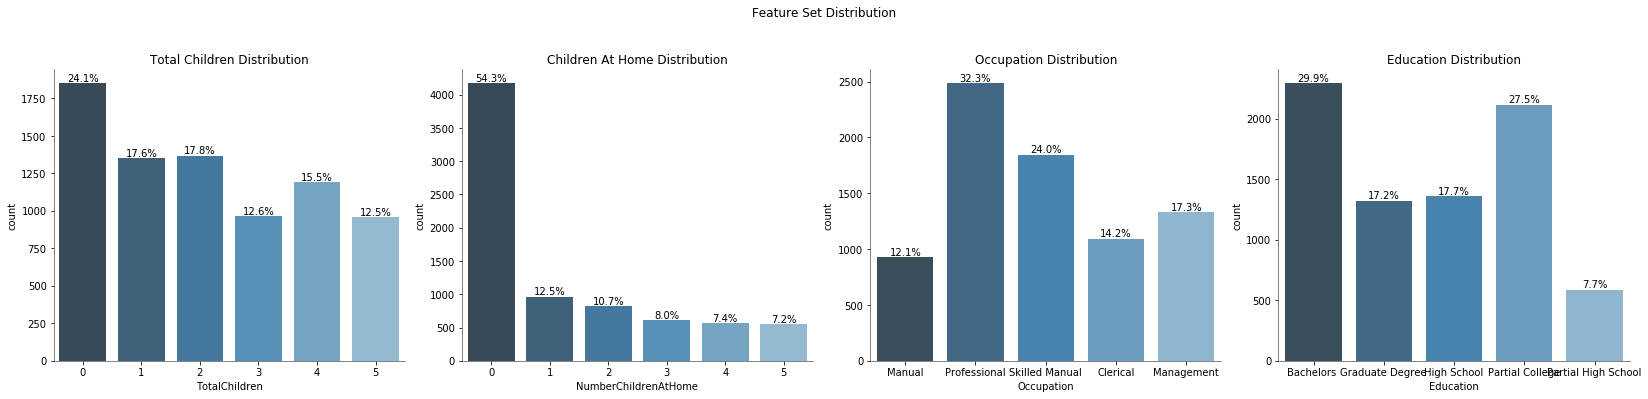

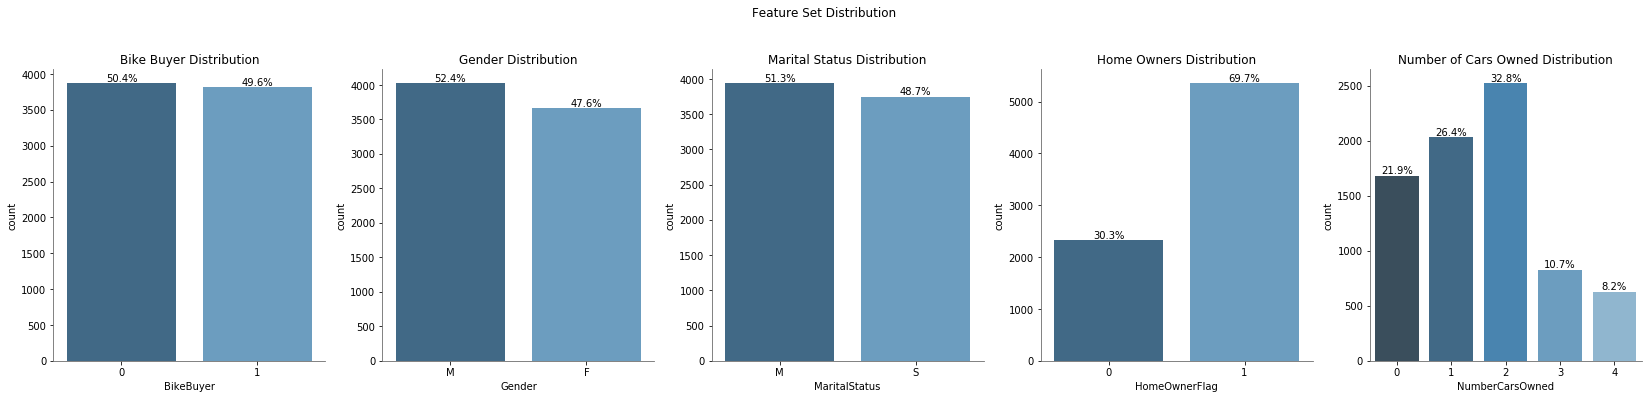

In [12]:
# displaying total orders the disribution of each of the dependent(categorical) columns
fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='TotalChildren', df=df, ax=axs[0], title='Total Children Distribution')
count_plot(feature='NumberChildrenAtHome', df=df, ax=axs[1], title='Children At Home Distribution')
count_plot(feature='Occupation', df=df, ax=axs[2], title='Occupation Distribution')
count_plot(feature='Education', df=df, ax=axs[3], title='Education Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(23, 5))
count_plot(feature='BikeBuyer', df=df, ax=axs[0], title='Bike Buyer Distribution')
count_plot(feature='Gender', df=df, ax=axs[1], title='Gender Distribution')
count_plot(feature='MaritalStatus', df=df, ax=axs[2], title='Marital Status Distribution')
count_plot(feature='HomeOwnerFlag', df=df, ax=axs[3], title='Home Owners Distribution')
count_plot(feature='NumberCarsOwned', df=df, ax=axs[4], title='Number of Cars Owned Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

The above plot shows the distribution of each of the categorical feature set, its unique values, and frequency count. 

From the first plot, it appears 24.1%(1852) of the dataset has 0 children, 17.6% amounting to around 1352 has 1 child, . . ., and 12.5%(961) have 5 children.

.

.

.

From the Last plot, 21.9%(1683) of the dataset has 0 car, 26.4% amounting to around 2029 have 1 child, . . ., and 8.2%(630) has 5 cars.

Of worthy note is the predictive column BikeBuyer which shows that 50.4% of the entire dataset did nor purchase a Bike while 49.6% purchased a bike. Meaning that we have a balanced dataset.

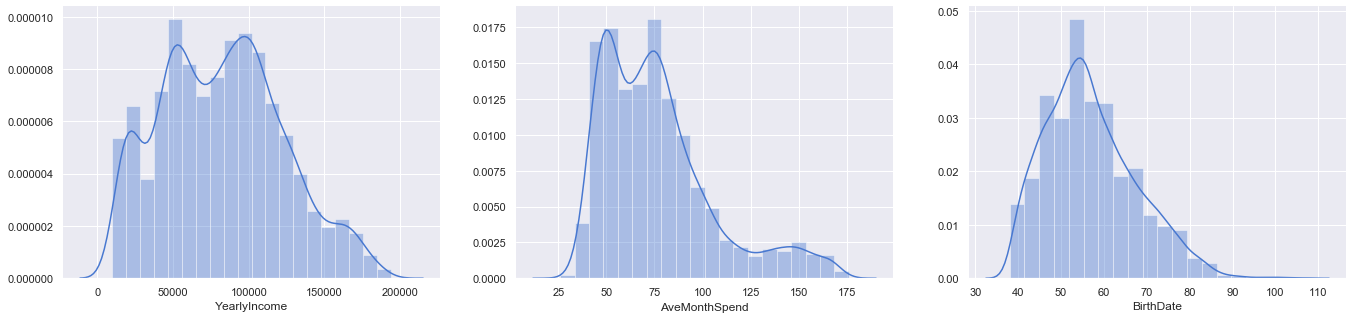

In [13]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(23, 5))
sns.despine(left=True)
sns.distplot(df['YearlyIncome'], bins=20, ax=axs[0])
sns.distplot(df['AveMonthSpend'], bins=20, ax=axs[1])
sns.distplot(df['BirthDate'], bins=20, ax=axs[2])
plt.show()

Of the three continuous columns in the dataset, it appears the Birthdate column is normally distributed, but this is not the case for the Yearly Income and Average Monthly Spend columns, and also the value range for Yearly income is widely dispersed, hence there would be need to pre-process these columns

# Bi-Variate Analysis

In [14]:
# engineering new columns Ageband and Monthlyincome
df['AgeBand']=df['BirthDate'].apply(lambda x: 'Young' if x<=40 else ('Middleaged' if x>=41 and x<=70 else 'Old'))
df['MonthlyIncome']=df['YearlyIncome'].apply(lambda x: x/12).apply(np.ceil).astype('int64')

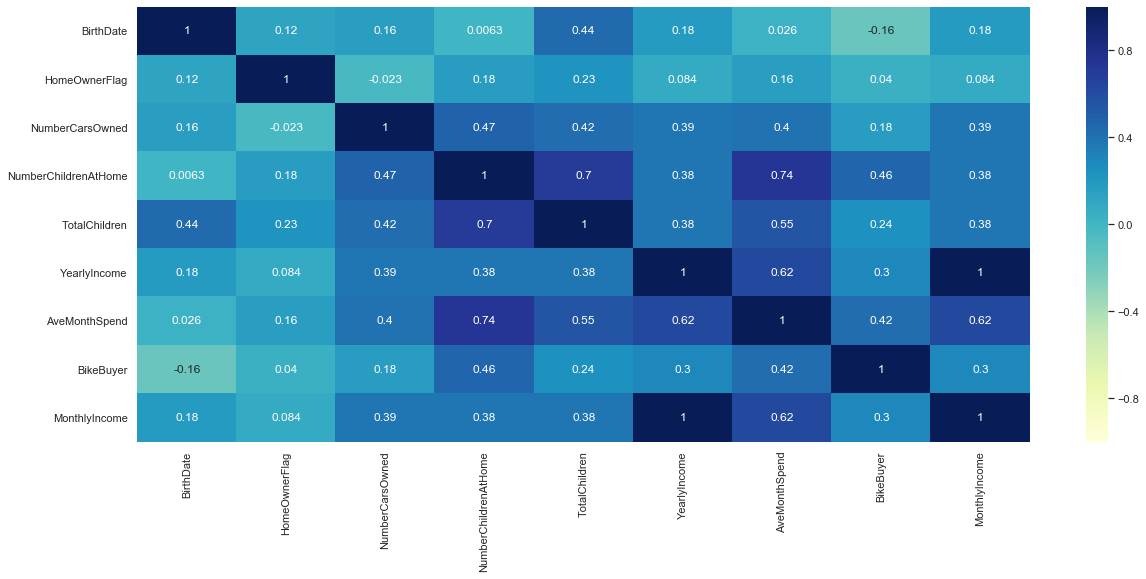

In [15]:
# plotting correlation heatmap
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
corr_matrix = df.corr()
ax=sns.heatmap(corr_matrix, vmin=-1, cmap="YlGnBu", annot=True)

I engineered two new columns AgeBand which seeks to draw insights from the age columns grading them into the categories Young(<40 yrs), Middleaged(41-70 yrs) and old(>70 yrs), using this column we can be able to tell various age bands and their BikeBuying behaviours. From the YearlyIncome column, a new column MonthlyIncome was binned, this will be used in place of YearlyIncome as it follows with the AverageMonthlySpend column and shares similar quartile ranges.

The above heatmap plot shows the correlation between the various numeric columns, it shows by how much each column correlates to other columns and most especially the target column BikeBuyer. As seen above, NumberChildrenAtHome, AverMonthSpend, MonthlyIncome has a stronger positive correlation with BikeBuyer and Birthdate has a slightly negative correlation with BikeBuyer

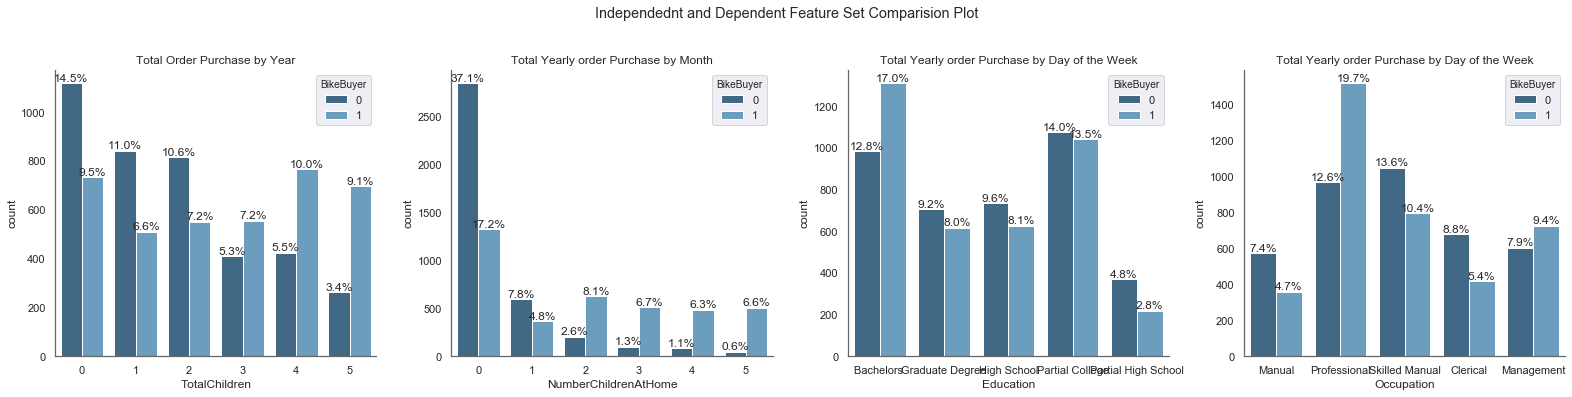

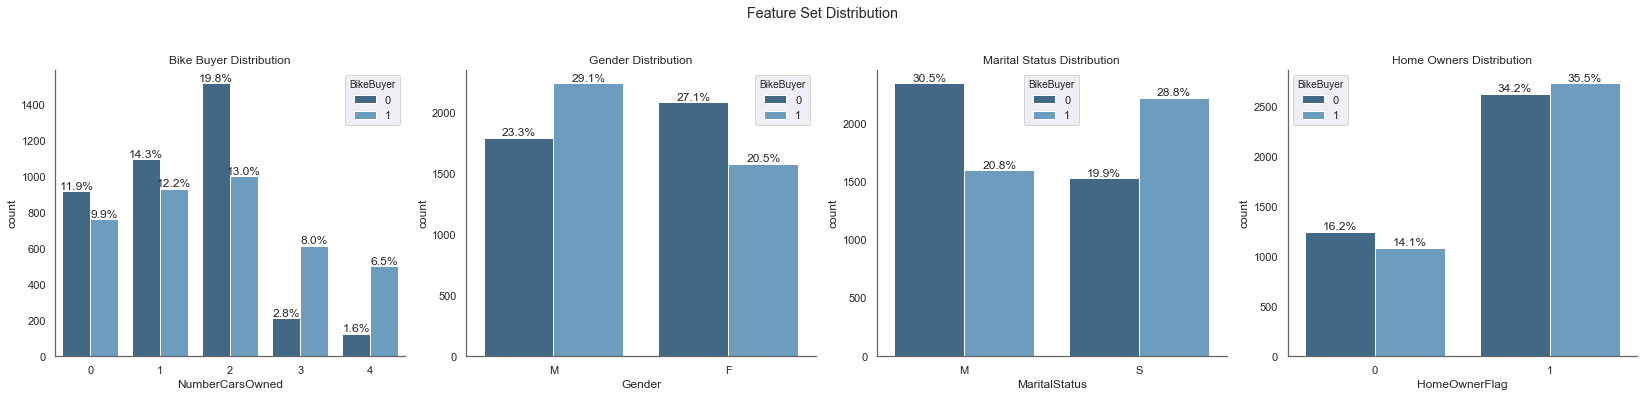

In [16]:
# displaying comparative plot between independednt and dependent feature set
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
count_plot(feature='TotalChildren', df=df, ax=axs[0], hue='BikeBuyer', title='Total Order Purchase by Year')
count_plot(feature='NumberChildrenAtHome', df=df, ax=axs[1], hue='BikeBuyer', title='Total Yearly order Purchase by Month')
count_plot(feature='Education', df=df, ax=axs[2], hue='BikeBuyer', title='Total Yearly order Purchase by Day of the Week')
count_plot(feature='Occupation', df=df, ax=axs[3], hue='BikeBuyer', title='Total Yearly order Purchase by Day of the Week')
#format_spines(ax, right_border=False)
plt.suptitle('Independednt and Dependent Feature Set Comparision Plot', y=1.1)
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='NumberCarsOwned', df=df, ax=axs[0], hue='BikeBuyer', title='Bike Buyer Distribution')
count_plot(feature='Gender', df=df, ax=axs[1], hue='BikeBuyer', title='Gender Distribution')
count_plot(feature='MaritalStatus', df=df, ax=axs[2], hue='BikeBuyer', title='Marital Status Distribution')
count_plot(feature='HomeOwnerFlag', df=df, ax=axs[3], hue='BikeBuyer', title='Home Owners Distribution')
#format_spines(ax, right_border=False)
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

The above plot shows the relationship between each of the categorical feature set and the target set BikeBuyer, its unique values, and frequency count. 

From the first plot, it appears that from the 24.1%(1852) of the dataset that has 0 children, 14.5%(1114) were non-BikeBuyers and 9.5%(761) were BikeBuyers. Out of the 17.6 (1352) of the dataset that had 1 child, 11%(1114) were non-BikeBuyers and 6.6%(507) were BikeBuyers. . . ., and 12.5%(961) have 5 children. In essence, the trend here is the more children a customer has the more likely he/she would purchase a bike

.

.

.

From the Last plot, from the 30.3%(2328) of the dataset that has 0 House, 16.2%(1245) were non-BikeBuyers and 14.1%(1083) were BikeBuyers, also from the 69.7%(5356) of the dataset that has 1 House, 34.2%(2628) were non-BikeBuyers and 35.5%(2727) were BikeBuyers. the trend here is that customers who own houses are more likely to buy a bike than customers who don't own houses. 

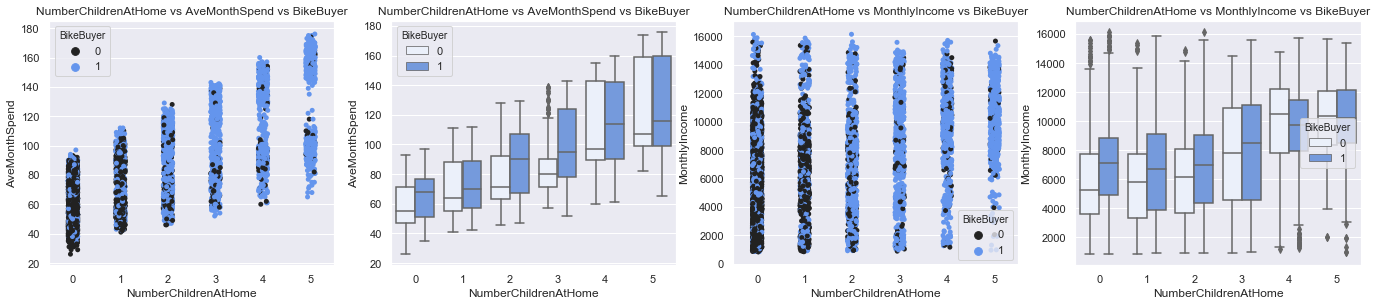

In [17]:
# displaying comparative plot between independednt and dependent feature set
f, axes = plt.subplots(ncols=4, figsize=(23.5,4.5))
colors = 'cornflowerblue'
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.stripplot(x="NumberChildrenAtHome", y="AveMonthSpend", hue='BikeBuyer', data=df, color=colors, ax=axes[0])
axes[0].set_title('NumberChildrenAtHome vs AveMonthSpend vs BikeBuyer')
sns.boxplot(x="NumberChildrenAtHome", y="AveMonthSpend", hue='BikeBuyer', data=df, color=colors, ax=axes[1])
axes[1].set_title('NumberChildrenAtHome vs AveMonthSpend vs BikeBuyer')
sns.stripplot(x="NumberChildrenAtHome", y="MonthlyIncome", data=df,  hue='BikeBuyer', jitter=True, color=colors, ax=axes[2])
axes[2].set_title('NumberChildrenAtHome vs MonthlyIncome vs BikeBuyer')
sns.boxplot(x="NumberChildrenAtHome", y="MonthlyIncome", hue='BikeBuyer', data=df, color=colors, ax=axes[3])
axes[3].set_title('NumberChildrenAtHome vs MonthlyIncome vs BikeBuyer')
plt.show()

The above plots show the relationship between the top 3 positively correlated independent columns(NumberChildrenAtHome, AveMonthSpend,  MonthlyIncome) and the dependent column(BikeBuyer). 

From the first strip plot it is observed that the average monthly spend of each household is positively correlated with the number of children, the more the children the greater the band of the AverageMonthSpend and also customers with more children at home are mostly BikeBuyera as the strip with more children is dominated with light blue dots which indicates BikeBuyers and the opposite for the case of 0 children

The second boxplot shows the same relationship, but with the various AverageMonthSpend percentile ranges for both BikeBuyers and non-BikeBuyers. For those with 0 children, non-buyers have a lower 25th, 50th, and 75th percentile AverageMonthSpend when compared to the BikeBuyers, . . ., for those with 5 children they share very close 25th and 75th percentile but different AverageMonthSpend as it is seen that the BikeBuyers tend to spend more on an average than the non-BikeBuyers. 
..
The same can be said for the third and fourth plots showing statistics of the comparison with the Monthly Income.

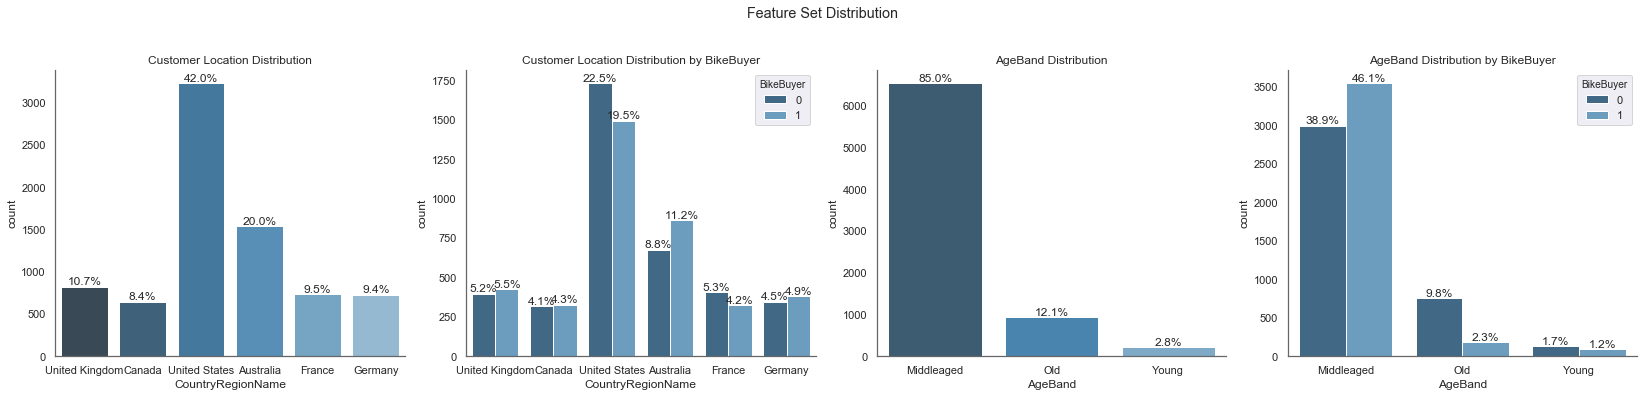

In [18]:

# displaying comparative plot between independednt and dependent feature set
fig, axs = plt.subplots(1, 4, figsize=(23, 5))
count_plot(feature='CountryRegionName', df=df, ax=axs[0], title='Customer Location Distribution')
count_plot(feature='CountryRegionName', df=df, ax=axs[1], hue='BikeBuyer', title='Customer Location Distribution by BikeBuyer')
count_plot(feature='AgeBand', df=df, ax=axs[2], title='AgeBand Distribution')
count_plot(feature='AgeBand', df=df, ax=axs[3], hue='BikeBuyer', title='AgeBand Distribution by BikeBuyer')
plt.suptitle('Feature Set Distribution', y=1.1)
plt.show()

The above plots show the relationship between customer location, the newly generated column AgeBand and the Target column BikeBuyer.

From the first count plot it is observed the majority of customers are located in the USA(42%), Australia(20%), UK(10.7%), . . ., and finally Canada(8.4%).

The second plot shows the distribution of BikeBuyers and non-Bikebuyers with respect to customer location.

The third plot shows the distribution of customer AgeBands, it's Observed that the majority of the customer in the dataset are Middleaged, followed by Old then finally Young customers.

The fourth plot shows the distribution of BikeBuyers and non-Bikebuyers with respect to AgeBand.

In [19]:
#Region_grouped = (df.groupby(['CountryRegionName', 'BikeBuyer'])[['CountryRegionName', 'BikeBuyer', 'payment_installments']]
                            # .agg({'payment_value':['count', 'mean', 'sum'], 'payment_installments': ['mean']})
               # ).sort_values(by=('payment_value','count'), ascending=False)
                 
#state_grouped

# Preprocessing

In [20]:
# displaying first rows of the dataset
df.head(3)

,City,StateProvinceName,CountryRegionName,PostalCode,BirthDate,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,BikeBuyer,AgeBand,MonthlyIncome
0,London,England,United Kingdom,W1Y 3RA,61,Bachelors,Manual,M,M,1,0,0,1,35455,70,1,Middleaged,2955
1,Cliffside,British Columbia,Canada,V8Y 1L1,59,Bachelors,Professional,M,S,0,1,0,0,43980,69,0,Middleaged,3665
2,Metchosin,British Columbia,Canada,V9,50,Bachelors,Skilled Manual,M,M,1,0,2,2,57713,102,0,Middleaged,4810


In [21]:
# mapping numbers to categorical columns
df['Gender'] = df['Gender'].apply(lambda x: 0 if x=='F' else 1)
df['MaritalStatus'] = df['MaritalStatus'].apply(lambda x: 0 if x=='S' else 1)
df['AgeBand'] = df['AgeBand'].apply(lambda x: 0 if x=='S' else 1)

In [22]:
#dropping non useful columns
df = df.drop(["City", "StateProvinceName", "PostalCode", "YearlyIncome"], axis=1)

In [23]:
# processing test_dataset for use in fiting onehotencoder due to data missing in both dataset
df_test['BirthDate'] = pd.to_datetime(df_test.BirthDate)
now = pd.to_datetime('now')
df_test['BirthDate'] = (now.year - df_test['BirthDate'].dt.year) - ((now.month - df_test['BirthDate'].dt.month) < 0)
df_test['AgeBand']=df_test['BirthDate'].apply(lambda x: 'Young' if x<=40 else ('Middleaged' if x>=41 and x<=70 else 'Old')).apply(lambda x: 0 if x=='S' else 1)
master_df = pd.concat([df, df_test], ignore_index=True, sort=False)

In [24]:
# OneHot encoding categorical colums
encode = OneHotEncoder().fit(master_df[['CountryRegionName', 'Education', 'Occupation','HomeOwnerFlag','AgeBand']])
df_trans = encode.transform(df[['CountryRegionName', 'Education', 'Occupation','HomeOwnerFlag','AgeBand']]).toarray()
cnames = encode.get_feature_names()
df_trans = pd.DataFrame(df_trans, columns=cnames)

df = df.join(df_trans)
df = df.drop(["CountryRegionName", "Education", "Occupation", "HomeOwnerFlag", "AgeBand"], axis=1)

In [25]:
# Robust scaling continous numerical colums due to presence of outliers and difference in column ranges
s_scal = master_df[['BirthDate', 'AveMonthSpend', 'MonthlyIncome']]
s_scale = RobustScaler(quantile_range=(25, 75)).fit(master_df[['BirthDate', 'AveMonthSpend', 'MonthlyIncome']])
df_scale = s_scale.transform(df[['BirthDate', 'AveMonthSpend', 'MonthlyIncome']])
df_scale = pd.DataFrame(df_scale, columns=s_scal.columns)

df = df.drop(["BirthDate", "AveMonthSpend", "MonthlyIncome"], axis=1)
df = df.join(df_scale)

In [26]:
# processing test dataset.
df_test = df_test.drop(["Title", "FirstName", "MiddleName", "LastName", "Suffix", "AddressLine1", "AddressLine2", "PhoneNumber"], axis=1)

float_columns = ['HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'AveMonthSpend']
for col in float_columns:
    df_test[col] = df_test[col].apply(np.ceil).astype('int64')
    
df_test['BirthDate'] = pd.to_datetime(df_test.BirthDate)
now = pd.to_datetime('now')
df_test['BirthDate'] = (now.year - df_test['BirthDate'].dt.year) - ((now.month - df_test['BirthDate'].dt.month) < 0)

df_test['AgeBand']=df_test['BirthDate'].apply(lambda x: 'Young' if x<=40 else ('Middleaged' if x>=41 and x<=70 else 'Old'))
df_test['MonthlyIncome']=df_test['YearlyIncome'].apply(lambda x: x/12).apply(np.ceil).astype('int64')

df_test['Gender'] = df_test['Gender'].apply(lambda x: 0 if x=='F' else 1)
df_test['MaritalStatus'] = df_test['MaritalStatus'].apply(lambda x: 0 if x=='S' else 1)
df_test['AgeBand'] = df_test['AgeBand'].apply(lambda x: 0 if x=='S' else 1)

df_test = df_test.drop(["City", "StateProvinceName", "PostalCode", "YearlyIncome", "BikeBuyer"], axis=1)

df_test_trans = encode.transform(df_test[['CountryRegionName', 'Education', 'Occupation','HomeOwnerFlag','AgeBand']]).toarray()
df_test_trans = pd.DataFrame(df_test_trans, columns=cnames)

df_test = df_test.join(df_test_trans)
df_test = df_test.drop(["CountryRegionName", "Education", "Occupation", "HomeOwnerFlag", "AgeBand"], axis=1)

df_test_scale = s_scale.transform(df_test[['BirthDate', 'AveMonthSpend', 'MonthlyIncome']])
df_test_scale = pd.DataFrame(df_test_scale, columns=s_scal.columns)

df_test = df_test.drop(["BirthDate", "AveMonthSpend", "MonthlyIncome"], axis=1)
df_test = df_test.join(df_test_scale)

In [27]:
# dataset shape
print(df.shape)
print(df_test.shape)

(7685, 28)
(3328, 28)


# Model Training

In [28]:
# mapping and spliting train and test data
X = df.drop('BikeBuyer', axis=1)
y = df['BikeBuyer']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random)

print(f'X_train dimension: {X_train.shape}')
print(f'X_test dimension: {X_test.shape}')
print(f'\ny_train dimension: {y_train.shape}')
print(f'y_test dimension: {y_test.shape}')

X_train dimension: (5763, 27)
X_test dimension: (1922, 27)

y_train dimension: (5763,)
y_test dimension: (1922,)


In [29]:
# defining and fitting classifiers
classifiers = {
    'log_reg': LogisticRegression(random_state = random),
    'rfc_clf': RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=None, max_features='auto', n_estimators=200, random_state = random),
    'svc_clf': SVC(probability=True, kernel='linear', random_state = random),
    'mlp_clf': MLPClassifier(random_state = random),
    'knc_clf': KNeighborsClassifier(),
    'dtc_clf': DecisionTreeClassifier(random_state = random),
}

trained_models = {}

for key, model in classifiers.items():
    model.fit(X_train, y_train)
    trained_models[key] = model

In [30]:
# Creating dataframe to hold, evaluate and print metrics
train_performance = create_dataset()

train_performance = model_analysis(trained_models, X_train, y_train, train_performance)

cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_performance.style.background_gradient(cmap=cm)

,acc,prec,rec,f1,auc,total_time
log_reg,0.7581,0.7741,0.7234,0.7476,0.8432,0.644
rfc_clf,0.7553,0.7569,0.7458,0.7513,0.8393,30.503


The above table holds the metrics of various classifiers trained on the same dataset and predicted on a single test set. it shows their individual accuracy, precision, recall, f1, AUC score and computation time.

The MLPClassifier appears to have the best score but also it has the highest computational time, SVC came second in performance with a lesser computational time when compared to that of MLP, . . ., DecisionTreeClassifier came in at the bottom performance.

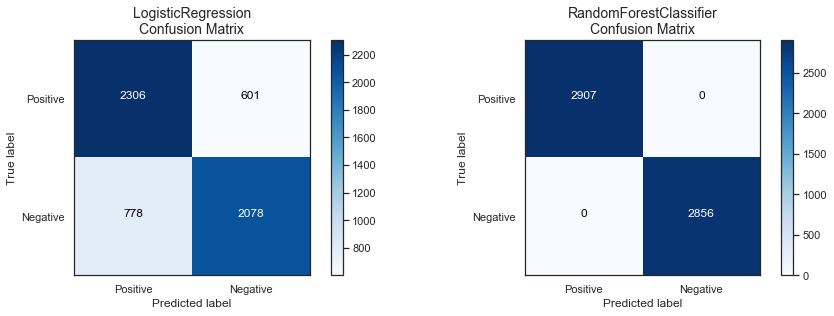

In [31]:
# computing and visualizing train confusion matrix
model_confusion_matrix(trained_models, X_train, y_train)

The Above confusion matrix shows the learning performance of the individual classifiers on the train set

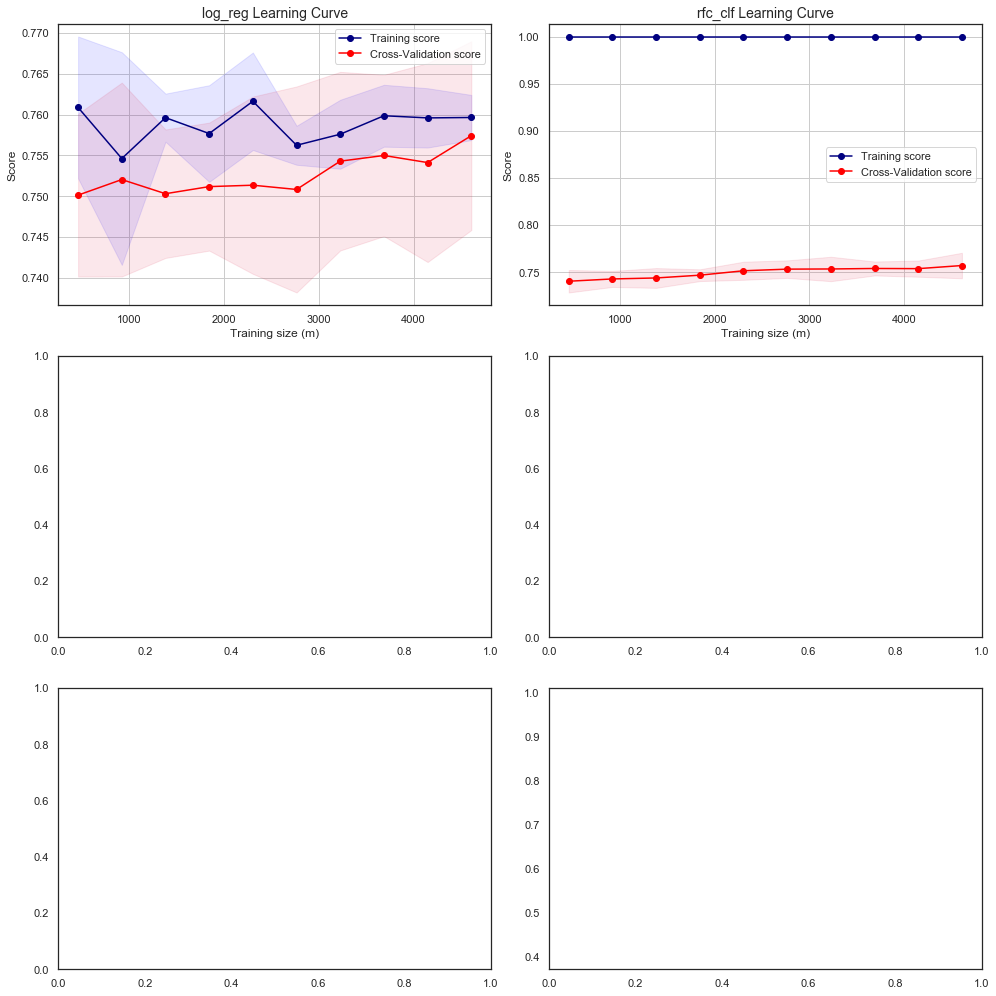

In [32]:
# computing and visualizing train learning curve
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(trained_models, X_train, y_train, (0.37, 1.01), cv=5, n_jobs=4)
plt.tight_layout()

The above curve displays the learning rate of each of the classifiers on the train set, the blue curve indicates the training score and the red indicates the 5 folds cross-validation score.

Too close to each other the plot indicates a problem of overfitting, too far apart then its a case of underfitting. So the better performing model will have both curves close but not too close and example is the SVC classifier 

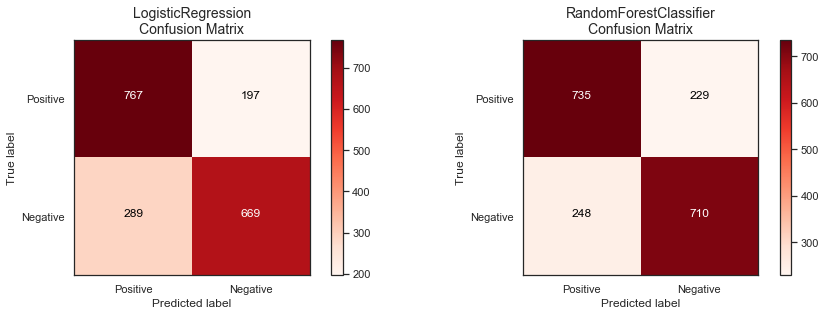

In [33]:
# computing and visualizing test confusion matrix
model_confusion_matrix(trained_models, X_test, y_test, cmap=plt.cm.Reds)

The Above confusion matrix shows the model performance of the individual classifiers on the train data Split test set, It indicates the number of True positives(Number of BikeBuyers predicted as buyers), False positives(Number of non-BikeBuyers predicted as buyers), True negatives(Number of non-BikeBuyers predicted as non-buyers) and False negatives(Number of non-BikeBuyers predicted as buyers)

It appears the SVC and Logistic regression classifiers had the most correct predictions.

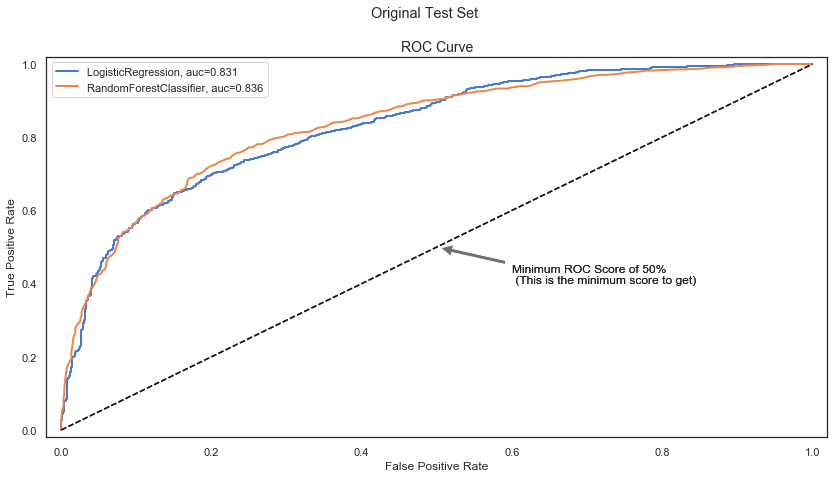

In [34]:
# computing and visualizing model set ROC Curve
plt.figure(figsize=(14, 7))

for key, model in trained_models.items():

    # Computing scores with cross_val_predict
    try:
        y_scores = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='decision_function')
    except:
        # Trees don't have decision_function but predict_proba
        y_probas = cross_val_predict(model, X_test, y_test, cv=5, 
                                     method='predict_proba')
        y_scores_tree = y_probas[:, 1]
        y_scores = y_scores_tree
        
    # ROC Curve
    model_name = model.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plot_roc_curve(fpr, tpr, y_test, y_scores, auc, label=model_name)
    plt.suptitle('Original Test Set')

In [35]:
# defining grid search parameter
param_grid_forest = [
    {
        'n_estimators': [5, 10, 20, 50],        
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 5],
        'max_depth': [None, 5, 10, 15],
        'min_samples_leaf': [1, 5],
        'bootstrap': [True, False]
    }
]

# defining anf fiting gridsearch on choosen classifier
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid_forest, cv=5,
                           scoring='roc_auc', verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1280 out of 1280 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
#selecting gridsearch best model
best_model = grid_search.best_estimator_

# defining classifiers for voting classifier

log_reg = LogisticRegression(random_state = random)
svm_clf = SVC(probability=True)
knn_clf = KNeighborsClassifier()
mlp_clf = MLPClassifier()
tree_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', log_reg), ('best_rf', best_model), ('svc', svm_clf), 
                ('knn', knn_clf), ('mlp', mlp_clf), ('tree', tree_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

# Training a Bagging model with 500 Decision Trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)

# Training a Bagging model with 500 Decision Trees
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

# Training a Bagging model with 500 Decision Trees
gboost_clf = GradientBoostingClassifier(
     n_estimators=500, learning_rate=1.0
)
gboost_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
voting = {
    'forest_grid': best_model,
    'voting_clf': voting_clf,
    'bag_clf': bag_clf,
    'ada_clf': ada_clf,
    'grad_boost': gboost_clf
}

trained_s_models = {}

for key, s_model in voting.items():
    s_model.fit(X_train, y_train)
    trained_s_models[key] = s_model

# Creating dataframe to hold metrics
train_s_performance = create_dataset()

# Evaluating models
train_s_performance = model_analysis(trained_s_models, X_train, y_train, train_s_performance)

# Result
cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_s_performance.style.background_gradient(cmap=cm)

,acc,prec,rec,f1,auc,total_time
forest_grid,0.7723,0.7892,0.7444,0.7627,0.8632,5.915
voting_clf,0.7678,0.7791,0.7497,0.7615,0.8554,236.497
bag_clf,0.7673,0.7899,0.73,0.7584,0.8543,44.317
ada_clf,0.7076,0.7073,0.7076,0.7036,0.708,0.981
grad_boost,0.733,0.7343,0.7234,0.7291,0.8166,66.048


In [ ]:
ensemble_performance = train_performance.append(train_s_performance)
ensemble_performance.index = ['LogisticRegression','RandomForest','SVMClassifier','MLPClassifier','KNNClassifier','DecisionTree','ForestGridSearch','VotingClassifier','BaggingClassifier','Adaboost','Gboost']
cm = sns.light_palette("lightgreen", as_cmap=True)
ensemble_performance.style.background_gradient(cmap=cm)

The above table displays the various classifiers trained and predicted on same dataset and their individual perfoemances.

In [ ]:
y_probas = cross_val_predict(best_model, X_train, 
                                 y_train, cv=10, method='predict_proba')
forest_probas = y_probas[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, forest_probas)

fig, ax = plt.subplots(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
format_spines(ax, right_border=False)
ax.set_title('Precision/Recall Curve', size=14)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(recalls, precisions, 'b-', linewidth=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.axis([0, 1, 0, 1])
ax.set_title('Precision versus Recall', size=14)
format_spines(ax, right_border=False)
plt.show()